In [1]:
# !pip install scikit-learn
# !pip install keras
# !pip install pydot
# !pip install matplotlib
# !pip install tensorflow


# Stock price prediction using our Keras’ LSTMs model trained on past stocks data.

## Step 1 - Import the Libraries

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from datetime import datetime, timedelta

## Step 2 – Reading our training data and getting our training data in shape

In [3]:
def load_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    # data.reset_index(inplace=True)
    data.drop(['Adj Close'], axis=1, inplace=True)
    return data

def feature_engineering(data):
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean() 
    data.dropna(inplace=True)
    return data

# Define the stock ticker and the training time frame
stock_ticker = "AAPL"
start_date = "2010-01-01"  # Start with a long enough historical period
end_date = "2023-01-01"   

# Load and prepare the training data
dataset_train = load_stock_data(stock_ticker, start_date, end_date)
dataset_train = feature_engineering(dataset_train)

#Print the shape of Dataframe  and Check for Null Values
print("Dataframe Shape: ", dataset_train.shape)
print("Null Value Present: ", dataset_train.isnull().values.any())

[*********************100%%**********************]  1 of 1 completed

Dataframe Shape:  (3223, 7)
Null Value Present:  False


## Step 3 - Setting the Target Variable, Selecting the Features, and Scaling

In [4]:
## Step 3 - Setting the Target Variable, Selecting the Features, and Scaling
output_var = pd.DataFrame(dataset_train['Close'])
features = ['Open', 'High', 'Low', 'Volume', 'SMA_10', 'SMA_50']

scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(dataset_train[features])
output_var_scaled = scaler.fit_transform(output_var)  # Scaling the target variable

# Convert back to DataFrame
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=dataset_train.index)
output_var_scaled = pd.DataFrame(columns=['Close'], data=output_var_scaled, index=dataset_train.index)


## Step 4 - Splitting to Training set and Test set

In [5]:
train_size = int(len(feature_transform) * 0.8)
X_train, X_test = feature_transform[:train_size], feature_transform[train_size:]
y_train, y_test = output_var_scaled[:train_size].values.ravel(), output_var_scaled[train_size:].values.ravel()

X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

## Step 5 - Building and Training the LSTM Model

In [6]:
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, X_train.shape[2]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100


c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 920us/step - loss: 2.0840e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 0.0031
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 5.3186e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 1.0557e-04
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 3.6657e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 1.9061e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 1.2879e-05
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 1.2538e-05
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 1.6284e-05
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 1.9986e-05
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3215e-05
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2633e-05
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7285e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - 

## Step 6 - Making the Prediction

In [7]:
y_pred = lstm.predict(X_test)

def predict_future_prices(model, last_known_data, days_to_predict, scaler, feature_columns):
    predictions = []
    current_data = last_known_data

    for _ in range(days_to_predict):
        # Predict the next day's price
        pred = model.predict(current_data)
        predictions.append(pred[0, 0])
        
        # Prepare the new data point for the next prediction
        # Remove the first row and append the predicted value
        current_data = np.roll(current_data, shift=-1, axis=1)
        current_data[0, -1, 0] = pred

    return predictions

days_to_predict = 10
last_known_data = np.array(feature_transform[-1:]).reshape((1, 1, len(features)))
future_predictions = predict_future_prices(lstm, last_known_data, days_to_predict, scaler, features)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
future_predictions = future_predictions.flatten()
future_predictions

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\2172239166.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


array([173.15973, 194.13455, 204.28265, 209.25471, 211.67773, 212.86253,
       213.44284, 213.72726, 213.86676, 213.93518], dtype=float32)

## Step 7- Evaluate Model

In [8]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE on Test Set: {mse:.4f}')
print(f'R2 Score on Test Set: {r2:.4f}')

MSE on Test Set: 0.0964
R2 Score on Test Set: -5.5836


## Step 8 - Plot Predicted vs True Adj Close Value – LSTM


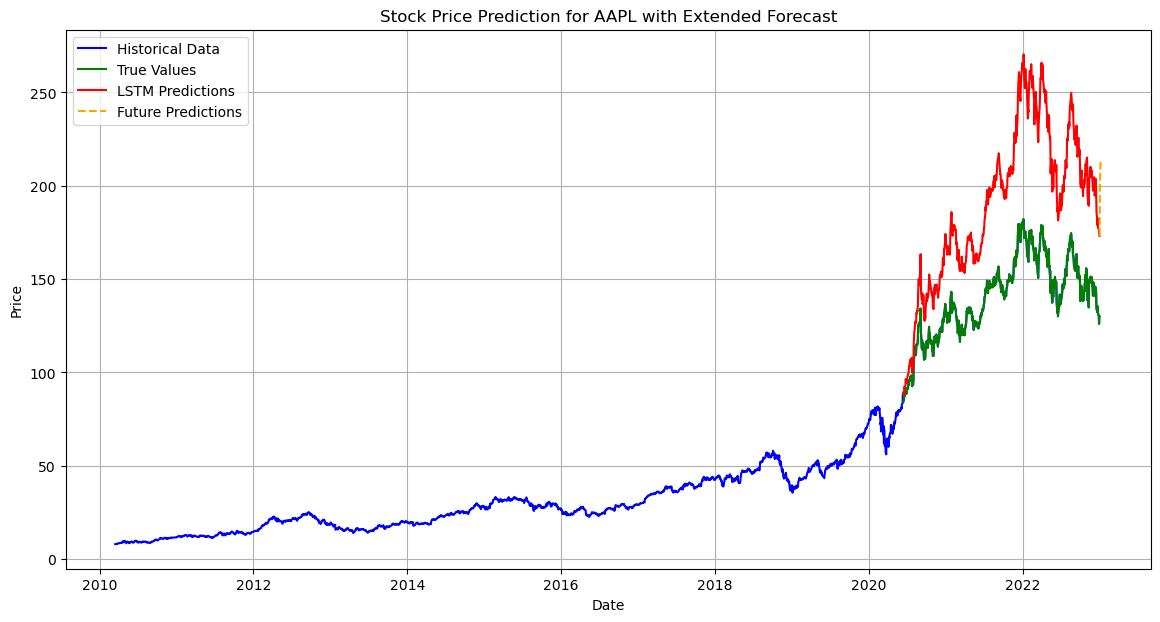

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare dates for plotting
last_date = dataset_train.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days_to_predict)

# Prepare historical dates for plotting
historical_dates = dataset_train.index
test_dates = historical_dates[-len(y_test):]
predicted_dates = historical_dates[-len(y_pred):]

# Plot historical and predicted data
plt.figure(figsize=(14, 7))
plt.plot(historical_dates, dataset_train['Close'], label='Historical Data', color='blue')
plt.plot(test_dates, scaler.inverse_transform(y_test.reshape(-1, 1)), label='True Values', color='green')
plt.plot(predicted_dates, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='LSTM Predictions', color='red')
plt.plot(future_dates, future_predictions, linestyle='--', color='orange', label='Future Predictions')

# Add labels and legend
plt.title(f'Stock Price Prediction for {stock_ticker} with Extended Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


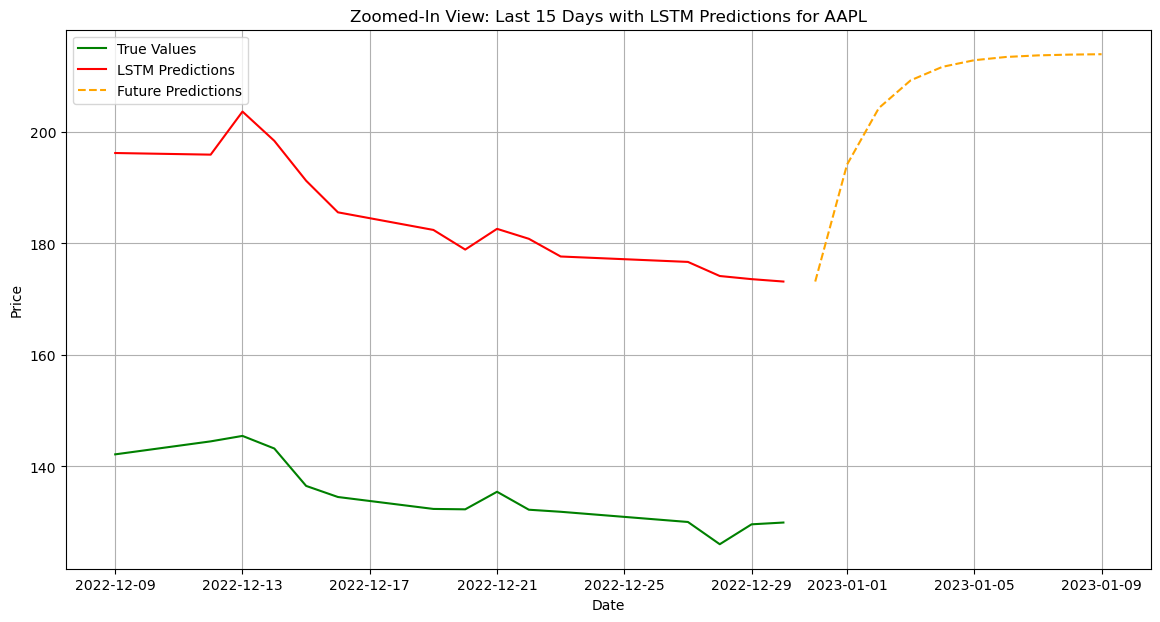

In [10]:
# Zoomed-In Plot for the Last 15 Days
plt.figure(figsize=(14, 7))

# Extracting the last 15 days data
zoom_start_date = dataset_train.index[-15]
zoom_end_date = dataset_train.index[-1]
zoom_dates = dataset_train.index[-15:]
zoom_true_values = scaler.inverse_transform(y_test[-15:].reshape(-1, 1))
zoom_lstm_predictions = scaler.inverse_transform(y_pred[-15:].reshape(-1, 1))
zoom_future_predictions = future_predictions[:15]  # Only the first 15 future days

plt.plot(zoom_dates, scaler.inverse_transform(output_var_scaled.loc[zoom_dates].values), label='True Values', color='green')
plt.plot(zoom_dates, zoom_lstm_predictions, label='LSTM Predictions', color='red')
plt.plot(future_dates[:15], zoom_future_predictions, linestyle='--', color='orange', label='Future Predictions')

# Add labels and legend
plt.title(f'Zoomed-In View: Last 15 Days with LSTM Predictions for {stock_ticker}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## **Simple model buy/sell/hold**

In [11]:
# Calculate the last number in zoom_lstm_predictions
last_lstm_prediction = zoom_lstm_predictions[-1]

# Calculate the average of the first three numbers in zoom_future_predictions
average_future_predictions = np.mean(zoom_future_predictions[:3])

# Determine the message to output
if last_lstm_prediction < average_future_predictions:
    message = f"According to the LSTM model, you should buy the {stock_ticker}"
elif last_lstm_prediction > average_future_predictions:
    message = f"According to the LSTM model, you should sell the {stock_ticker}"
else:
    message = "According to the LSTM model, the market seems to not change significantly"

print(message)

According to the LSTM model, you should buy the AAPL


## Backtesting on the model performance

In [12]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

def load_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data.drop(['Adj Close'], axis=1, inplace=True)
    return data

def feature_engineering(data):
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean() 
    data.dropna(inplace=True)
    return data

def predict_future_prices(model, last_known_data, days_to_predict, scaler, feature_columns):
    predictions = []
    current_data = last_known_data

    for _ in range(days_to_predict):
        # Predict the next day's price
        pred = model.predict(current_data)
        predictions.append(pred[0, 0])

        # Prepare the new data point for the next prediction
        # Remove the first row and append the predicted value
        current_data = np.roll(current_data, shift=-1, axis=1)
        current_data[0, -1, 0] = pred

    return predictions

# Define the stock ticker and the training time frame
stock_ticker = "AAPL"
start_date = "2010-01-01"
end_date = "2023-01-01"

# Load and prepare the training data
dataset_train = load_stock_data(stock_ticker, start_date, end_date)
dataset_train = feature_engineering(dataset_train)

# Initialize the DataFrame to store the end dates and related values
end_dates_df = pd.DataFrame(columns=["End Date", "Close", "Last LSTM Prediction", "Avg Future Predictions"])

# Start the loop to add one day until 2023-01-31
while end_date != "2023-01-31": #change this date for different period to test
    # Convert end_date string to datetime object
    end_date_dt = datetime.strptime(end_date, "%Y-%m-%d")
    
    # Increment the date by one day
    end_date_dt += timedelta(days=1)
    
    # Convert back to string format
    end_date = end_date_dt.strftime("%Y-%m-%d")
    
    # Load and prepare the data for the new end date
    dataset_train = load_stock_data(stock_ticker, start_date, end_date)
    dataset_train = feature_engineering(dataset_train)
    
    output_var = pd.DataFrame(dataset_train['Close'])
    features = ['Open', 'High', 'Low', 'Volume', 'SMA_10', 'SMA_50']

    scaler = MinMaxScaler()
    feature_transform = scaler.fit_transform(dataset_train[features])
    output_var_scaled = scaler.fit_transform(output_var)  # Scaling the target variable

    # Convert back to DataFrame
    feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=dataset_train.index)
    output_var_scaled = pd.DataFrame(columns=['Close'], data=output_var_scaled, index=dataset_train.index)

    train_size = int(len(feature_transform) * 0.8)
    X_train, X_test = feature_transform[:train_size], feature_transform[train_size:]
    y_train, y_test = output_var_scaled[:train_size].values.ravel(), output_var_scaled[train_size:].values.ravel()

    X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

    lstm = Sequential()
    lstm.add(LSTM(32, input_shape=(1, X_train.shape[2]), activation='relu', return_sequences=False))
    lstm.add(Dense(1))
    lstm.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False) 
    y_pred = lstm.predict(X_test)

    # Predict future prices
    days_to_predict = 10
    last_known_data = np.array(feature_transform[-1:]).reshape((1, 1, len(features)))
    future_predictions = predict_future_prices(lstm, last_known_data, days_to_predict, scaler, features)
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    future_predictions = future_predictions.flatten()
    
    # Prepare dates for plotting
    last_date = dataset_train.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days_to_predict)

    # Prepare historical dates for plotting
    historical_dates = dataset_train.index
    test_dates = historical_dates[-len(y_test):]
    predicted_dates = historical_dates[-len(y_pred):]
    
    # Extract the last 15 days data
    zoom_start_date = dataset_train.index[-15]
    zoom_end_date = dataset_train.index[-1]
    zoom_dates = dataset_train.index[-15:]
    zoom_true_values = scaler.inverse_transform(y_test[-15:].reshape(-1, 1))
    zoom_lstm_predictions = scaler.inverse_transform(y_pred[-15:].reshape(-1, 1))
    zoom_future_predictions = future_predictions[:15]  # Only the first 15 future days
    
    # Calculate the last number in zoom_lstm_predictions
    last_lstm_prediction = zoom_lstm_predictions[-1]

    # Calculate the average of the first three numbers in zoom_future_predictions
    average_future_predictions = np.mean(zoom_future_predictions[:3])

    # Record the 'Close' value, last_lstm_prediction, and average_future_predictions
    new_row = pd.DataFrame({
        "End Date": [end_date],
        "Close": [dataset_train['Close'].iloc[-1]],  # Last close value in the current DataFrame
        "Last LSTM Prediction": [last_lstm_prediction],
        "Avg Future Predictions": [average_future_predictions]
    })
    end_dates_df = pd.concat([end_dates_df, new_row], ignore_index=True)

# Print the DataFrame with end dates and predictions
print(end_dates_df)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 946us/step - loss: 1.7050e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.0026
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 4.3873e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 6.3335e-05
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 1.7948e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 1.0543e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 9.0967e-06
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 9.0764e-06
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 1.0455e-05
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 9.4418e-06
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 1.0714e-05
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 1.2485e-05
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 1.5526e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 905us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  end_dates_df = pd.concat([end_dates_df, new_row], ignore_index=True)
[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 905us/step - loss: 1.0166e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 0.0027
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 3.9952e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 7.9047e-05
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 2.3437e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 1.2964e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 1.2574e-05
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 1.6634e-05
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 1.8882e-05
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 1.8221e-05
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 1.7704e-05
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 1.5862e-05
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 1.3386e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 888us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.8280e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0040
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.5658e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3484e-04
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6828e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0278e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1630e-05
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.8862e-06
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.4841e-06
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.5192e-06
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.5161e-06
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.5308e-06
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0116e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0058e-05
Epo

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.0413e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0023
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.4532e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0414e-04
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.4226e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7397e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1231e-05
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.0970e-06
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.0584e-06
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.5276e-06
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0777e-05
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3118e-05
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5561e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6713e-05
Epo

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.3243e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0036
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3342e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4078e-04
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.2951e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0053e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.4041e-06
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.3300e-06
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.2119e-06
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.7068e-06
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0132e-05
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4004e-05
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6792e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9992e-05
Epo

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.0495e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0027
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.8883e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.7320e-05
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9636e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.7922e-06
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.3299e-06
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.3186e-06
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.8488e-06
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.8375e-06
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.1855e-06
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.9866e-06
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.2446e-06
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7801e-06
Epo

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.1329e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0026
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.0009e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.7190e-05
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9449e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6056e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7165e-05
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5623e-05
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9272e-05
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2816e-05
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.5271e-05
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.4539e-05
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.9685e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.2795e-05
Epo

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.0327e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0021
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.4534e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.8336e-05
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9829e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4332e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4940e-05
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8128e-05
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7917e-05
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8887e-05
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8058e-05
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5431e-05
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3075e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.9140e-06
Epo

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 932us/step - loss: 1.3446e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 0.0027
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 4.5941e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 8.8230e-05
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 2.9110e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 1.4314e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1510e-05
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1400e-05  
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 1.0450e-05
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0085e-05
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 1.0755e-05
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 1.1705e-05
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 1.7432e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 1000us/step - loss: 2.8466e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 0.0029
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 4.8431e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 9.9288e-05
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 2.9518e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 1.1459e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 7.8403e-06
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 7.4083e-06
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 8.6962e-06
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 8.9968e-06
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 1.5823e-05
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 9.8536e-06
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 1.9166e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 890u

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 824us/step - loss: 1.5989e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 0.0028
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 5.2249e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 1.3171e-04
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 4.0658e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 1.6078e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 1.1632e-05
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 9.8983e-06
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 1.0016e-05
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 1.1274e-05
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 1.2444e-05
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 1.7066e-05
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 1.7548e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 826us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 816us/step - loss: 9.7046e-05
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 0.0026
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 4.0428e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 7.9450e-05
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 1.8101e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 7.1286e-06
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 5.5242e-06
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 6.5797e-06
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 5.6126e-06
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 7.9812e-06
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 6.6109e-06
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 5.9761e-06
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 5.1385e-06
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 848us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 910us/step - loss: 9.9512e-05
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 0.0023
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 2.9470e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 5.8006e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 2.0416e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 1.6124e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 2.1052e-05
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 1.6944e-05
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 2.2811e-05
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 1.8303e-05
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 1.9445e-05
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 1.8165e-05
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 1.7766e-05
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 911us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 892us/step - loss: 1.2818e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 0.0036
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 4.5299e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 7.1390e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 2.7025e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 9.1555e-06
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 5.5797e-06
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 4.7240e-06
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 4.9803e-06
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 5.6506e-06
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 1.4574e-05
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 1.6076e-05
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 3.6920e-05
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 975us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 898us/step - loss: 1.3518e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 0.0027
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 3.5942e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 7.1581e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 2.1757e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 1.3674e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 1.4132e-05
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 1.5626e-05
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5803e-05
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 1.6900e-05
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 1.5002e-05
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 1.4576e-05
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 1.3334e-05
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/s

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 948us/step - loss: 9.4803e-05
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 0.0015
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1513e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 2.4132e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 1.8549e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 2.6757e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 2.8725e-05
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 3.1513e-05
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 3.2361e-05
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 3.5504e-05
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 3.6635e-05
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7021e-05
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 3.3443e-05
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/ste

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 929us/step - loss: 1.0246e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 0.0022
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 3.1104e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 5.2320e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 1.7685e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 1.4993e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 1.4854e-05
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 1.7124e-05
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 1.7301e-05
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 1.6562e-05
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 1.5325e-05
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 1.3515e-05
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 1.1222e-05
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 911us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 914us/step - loss: 4.8186e-05
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 0.0012
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 8.3092e-05
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 6.4649e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 6.5830e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 7.4830e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 7.1415e-05
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 5.6240e-05
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 5.6105e-05
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 4.5754e-05
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 5.0452e-05
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 4.9807e-05
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 5.1265e-05
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 949us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 893us/step - loss: 1.1024e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 0.0028
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 3.6164e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2826e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 1.8265e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 8.4709e-06
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 1.1105e-05
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 1.3015e-05
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0175e-05
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 1.2270e-05
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 1.0958e-05
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 1.0517e-05
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 9.0239e-06
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/ste

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 868us/step - loss: 1.7332e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 0.0039
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 6.7964e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 1.2138e-04
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 4.4227e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 2.0882e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 9.8352e-06
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 1.0314e-05
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 8.0156e-06
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 8.4206e-06
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 7.5049e-06
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 1.0461e-05
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 9.0309e-06
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 873us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 873us/step - loss: 2.0740e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032 
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 4.4161e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 8.8308e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0078e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 1.4153e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6103e-06
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 6.1673e-06
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 6.1181e-06
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 5.6424e-06
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 1.0076e-05
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 1.0646e-05
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 9.4511e-06
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 870us/step - loss: 8.4493e-05
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 0.0027
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 3.6412e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 6.0050e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 2.1757e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 1.0262e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 7.9319e-06
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 6.9617e-06
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 7.0446e-06
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 6.8206e-06
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8687e-06
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 7.5351e-06
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 7.2321e-06
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/s

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 900us/step - loss: 7.7174e-05
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 0.0023
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 2.4003e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 2.9357e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 8.7985e-06
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 6.0554e-06
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6435e-06
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2971e-06 
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 1.3688e-05
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 5.7761e-06
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 1.0110e-05
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.7512e-06
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8778e-06
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step -

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 865us/step - loss: 1.7463e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 0.0038
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 6.6669e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 1.2979e-04
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 4.3116e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 2.9300e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 3.1012e-05
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2618e-05
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3530e-05
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 3.3443e-05
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 3.2436e-05
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 3.0956e-05
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7852e-05
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step 

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 907us/step - loss: 1.4660e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 0.0037
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 5.7717e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 9.1705e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 3.0536e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3444e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3162e-06
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1193e-05 
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.2143e-06
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 7.5040e-06
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9650e-06
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 6.4701e-06
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 8.9222e-06
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - l

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 830us/step - loss: 1.1783e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 0.0033
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 5.0330e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.7133e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3619e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 1.6820e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.0129e-06
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 6.5344e-06
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4559e-06 
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0854e-06
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2028e-06
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0234e-06
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1262e-06
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 5

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 881us/step - loss: 1.4681e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0035
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 4.8704e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 8.4691e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 3.6363e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 1.9678e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 1.2909e-05
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 1.1385e-05
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 1.0856e-05
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 1.1649e-05
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 1.2669e-05
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 1.4531e-05
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 1.5734e-05
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/s

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 871us/step - loss: 8.3317e-05
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 0.0027
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 3.7604e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 5.5165e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 1.8914e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 1.7139e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 1.7796e-05
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 2.0809e-05
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 2.2109e-05
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 2.2129e-05
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 1.9924e-05
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 1.9526e-05 
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 1.6760e-05
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 997u

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 895us/step - loss: 8.9451e-05
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 0.0029
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8828e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7896e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6941e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 8.6322e-06
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9251e-06
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 6.9549e-06
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 5.5532e-06
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1152e-06
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4666e-06 
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 6.4943e-06
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2272e-06  
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss:

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 861us/step - loss: 1.0809e-04
Epoch 2/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 0.0027
Epoch 3/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 2.8209e-04
Epoch 4/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 4.6386e-05
Epoch 5/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 1.5769e-05
Epoch 6/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 1.0513e-05
Epoch 7/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 1.4069e-05
Epoch 8/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 1.3446e-05
Epoch 9/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 1.4564e-05
Epoch 10/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 1.5336e-05
Epoch 11/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 1.5123e-05
Epoch 12/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 1.7051e-05
Epoch 13/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 1.4584e-05
Epoch 14/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 904us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\1719146762.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
      End Date       Close Last LSTM Prediction  Avg Future Predictions
0   2023-01-02  129.929993          [170.67528]              184.814575
1   2023-01-03  129.929993          [136.17836]              138.089355
2   2023-01-04  125.070000          [164.51788]              176.907944
3   2023-01-05  126.360001          [158.95558]              166.664902
4   2023-01-06  125.019997           [159.2533]              169.390060
5   2023-01-07  129.619995          [161.49915]              170.905807
6   2023-01-08  129.619995           [161.7442]              171.995850
7   2023-01-09  129.619995          [133.33025]              134.894470
8   2023-01-10  130.149994          [164.71405]              174.492783
9   2023-01-11  130.729996          [163.55885]     

#### Rating performance by buying/selling every business day based on the 3 day prediction

In [13]:
# Adding the 'action' column based on logic
end_dates_df['action'] = 0  # Default to hold
end_dates_df.loc[end_dates_df['Last LSTM Prediction'] > end_dates_df['Close'], 'action'] = 1  # Buy
end_dates_df.loc[end_dates_df['Last LSTM Prediction'] < end_dates_df['Close'], 'action'] = -1  # Sell

# Now proceed with the original loop that handles buying, selling, and tracking money

# Initialize variables for shares and money
initial_shares = 100
shares_on_hand = initial_shares
money_spent = 0
money_earned = 0

# Get the closing price of the first day in dataset_train
first_date = dataset_train.index[0]
first_close_price = dataset_train.loc[first_date, 'Close']

# Track the money spent on initial 100 shares
initial_investment = initial_shares * first_close_price

# Lists to store results for each day
shares_on_hand_list = []
money_spent_list = []
money_earned_list = []

# Iterate over the rows in end_dates_df
for index, row in end_dates_df.iterrows():
    # Use the 'Close' column from end_dates_df
    close_price = row['Close']

    action = row['action']

    if action == 1:
        # Buy one share
        shares_on_hand += 1
        money_spent += close_price
    elif action == -1:
        # Sell one share
        shares_on_hand -= 1
        money_earned += close_price
    # If action == 0, do nothing

    # Record the shares and money spent/earned for the day
    shares_on_hand_list.append(shares_on_hand)
    money_spent_list.append(money_spent)
    money_earned_list.append(money_earned)

# Add the new columns to the end_dates_df DataFrame
end_dates_df['Shares on Hand'] = shares_on_hand_list
end_dates_df['Money Spent'] = money_spent_list
end_dates_df['Money Earned'] = money_earned_list

# Print the DataFrame with the new columns
print(end_dates_df)

# Get the closing price of the last day in dataset_train
last_date = dataset_train.index[-1]
last_close_price = dataset_train.loc[last_date, 'Close']

# Calculate the number of shares bought (excluding the initial 100 shares)
shares_bought = shares_on_hand - initial_shares

# Get the last value in the Money Spent column
last_money_spent = end_dates_df['Money Spent'].iloc[-1]

# Calculate the total value of the shares bought at the last day's closing price
total_value_from_bought_shares = shares_bought * last_close_price

# Calculate the money spent on buying the shares including losses and gains
# Subtract the initial investment for the initial 100 shares
money_spent_on_bought_shares = last_money_spent - initial_investment

# Calculate net gain/loss from selling the bought shares
money_earned_from_selling_bought_shares = total_value_from_bought_shares - money_spent_on_bought_shares

# Print the results
print(f"Closing Price on the Last Day: {last_close_price}")
print(f"Total Value of Bought Shares at Last Day's Closing Price: {total_value_from_bought_shares}")
print(f"Money Spent on Bought Shares: {money_spent_on_bought_shares}")
print(f"Net Gain/Loss from Selling Bought Shares: {money_earned_from_selling_bought_shares}")


      End Date       Close Last LSTM Prediction  Avg Future Predictions  \
0   2023-01-02  129.929993          [170.67528]              184.814575   
1   2023-01-03  129.929993          [136.17836]              138.089355   
2   2023-01-04  125.070000          [164.51788]              176.907944   
3   2023-01-05  126.360001          [158.95558]              166.664902   
4   2023-01-06  125.019997           [159.2533]              169.390060   
5   2023-01-07  129.619995          [161.49915]              170.905807   
6   2023-01-08  129.619995           [161.7442]              171.995850   
7   2023-01-09  129.619995          [133.33025]              134.894470   
8   2023-01-10  130.149994          [164.71405]              174.492783   
9   2023-01-11  130.729996          [163.55885]              172.411575   
10  2023-01-12  133.490005          [165.95926]              176.284439   
11  2023-01-13  133.410004          [138.75644]              140.159866   
12  2023-01-14  134.75999

#### 30 day prediction backtest with stop-loss

In [14]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

def load_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data.drop(['Adj Close'], axis=1, inplace=True)
    return data

def feature_engineering(data):
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean() 
    data.dropna(inplace=True)
    return data

def predict_future_prices(model, last_known_data, days_to_predict, scaler, feature_columns):
    predictions = []
    current_data = last_known_data

    for _ in range(days_to_predict):
        # Predict the next day's price
        pred = model.predict(current_data)
        predictions.append(pred[0, 0])

        # Prepare the new data point for the next prediction
        # Remove the first row and append the predicted value
        current_data = np.roll(current_data, shift=-1, axis=1)
        current_data[0, -1, 0] = pred

    return predictions

def calculate_slope(prices, window=5):
    if len(prices) < window:
        return np.nan  # Not enough data to calculate slope
    
    x = np.arange(window)
    y = prices[-window:]
    slope, _ = np.polyfit(x, y, 1)
    return slope

# Define the stock ticker and the training time frame
stock_ticker = "AAPL"
start_date = "2010-01-01"
end_date = "2023-01-01"

# Load and prepare the training data
dataset_train = load_stock_data(stock_ticker, start_date, end_date)
dataset_train = feature_engineering(dataset_train)

# Initialize the DataFrame to store the end dates and related values
end_dates_df = pd.DataFrame(columns=["End Date", "Close", "Last LSTM Prediction", "Avg Future Predictions", "Slope"])

# Start the loop to add one day until 2023-01-31
while end_date != "2023-01-31":
    # Convert end_date string to datetime object
    end_date_dt = datetime.strptime(end_date, "%Y-%m-%d")
    
    # Increment the date by one day
    end_date_dt += timedelta(days=1)
    
    # Convert back to string format
    end_date = end_date_dt.strftime("%Y-%m-%d")
    
    # Load and prepare the data for the new end date
    dataset_train = load_stock_data(stock_ticker, start_date, end_date)
    dataset_train = feature_engineering(dataset_train)
    
    output_var = pd.DataFrame(dataset_train['Close'])
    features = ['Open', 'High', 'Low', 'Volume', 'SMA_10', 'SMA_50']

    scaler = MinMaxScaler()
    feature_transform = scaler.fit_transform(dataset_train[features])
    output_var_scaled = scaler.fit_transform(output_var)  # Scaling the target variable

    # Convert back to DataFrame
    feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=dataset_train.index)
    output_var_scaled = pd.DataFrame(columns=['Close'], data=output_var_scaled, index=dataset_train.index)

    train_size = int(len(feature_transform) * 0.8)
    X_train, X_test = feature_transform[:train_size], feature_transform[train_size:]
    y_train, y_test = output_var_scaled[:train_size].values.ravel(), output_var_scaled[train_size:].values.ravel()

    X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

    lstm = Sequential()
    lstm.add(LSTM(32, input_shape=(1, X_train.shape[2]), activation='relu', return_sequences=False))
    lstm.add(Dense(1))
    lstm.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False) 
    y_pred = lstm.predict(X_test)

    # Predict future prices
    days_to_predict = 10
    last_known_data = np.array(feature_transform[-1:]).reshape((1, 1, len(features)))
    future_predictions = predict_future_prices(lstm, last_known_data, days_to_predict, scaler, features)
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    future_predictions = future_predictions.flatten()
    
    # Prepare dates for plotting
    last_date = dataset_train.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days_to_predict)

    # Prepare historical dates for plotting
    historical_dates = dataset_train.index
    test_dates = historical_dates[-len(y_test):]
    predicted_dates = historical_dates[-len(y_pred):]
    
    # Extract the last 15 days data
    zoom_start_date = dataset_train.index[-15]
    zoom_end_date = dataset_train.index[-1]
    zoom_dates = dataset_train.index[-15:]
    zoom_true_values = scaler.inverse_transform(y_test[-15:].reshape(-1, 1))
    zoom_lstm_predictions = scaler.inverse_transform(y_pred[-15:].reshape(-1, 1))
    zoom_future_predictions = future_predictions[:15]  # Only the first 15 future days
    
    # Calculate the last number in zoom_lstm_predictions
    last_lstm_prediction = zoom_lstm_predictions[-1]

    # Calculate the average of the first three numbers in zoom_future_predictions
    average_future_predictions = np.mean(zoom_future_predictions[:3])

    # Calculate the slope of the last 5 days of closing prices
    slope = calculate_slope(dataset_train['Close'].values[-5:])

    # Record the 'Close' value, last_lstm_prediction, average_future_predictions, and slope
    new_row = pd.DataFrame({
        "End Date": [end_date],
        "Close": [dataset_train['Close'].iloc[-1]],  # Last close value in the current DataFrame
        "Last LSTM Prediction": [last_lstm_prediction],
        "Avg Future Predictions": [average_future_predictions],
        "Slope": [slope]  # Store the calculated slope
    })
    end_dates_df = pd.concat([end_dates_df, new_row], ignore_index=True)

# Print the DataFrame with end dates, predictions, and slopes
print(end_dates_df)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 919us/step - loss: 1.5494e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 0.0029
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3627e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 1.0593e-04
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 3.0375e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 1.5980e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 1.3741e-05
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 2.6568e-05
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 9.6930e-06
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 1.5153e-05
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 8.5784e-06
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 9.3838e-06
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 1.6176e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/s

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:142: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  end_dates_df = pd.concat([end_dates_df, new_row], ignore_index=True)
[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 889us/step - loss: 7.9732e-05
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4126e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 6.2605e-05
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 1.9035e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 1.0903e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 9.8836e-06
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 9.8234e-06
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 1.0574e-05
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 1.0357e-05
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 1.1090e-05
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 1.2059e-05
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 1.6473e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/ste

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 871us/step - loss: 1.3352e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 0.0039
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 5.8348e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 9.4507e-05
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 2.5988e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 1.0416e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 4.7418e-06
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 4.9824e-06
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 3.8819e-06
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 3.9316e-06
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 4.0921e-06
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 3.9939e-06
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 3.8479e-06
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 852us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 929us/step - loss: 1.1788e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 0.0029
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 5.7437e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 1.1803e-04
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 3.2934e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 1.5519e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 1.3260e-05
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 1.3201e-05
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 9.9821e-06
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 8.0790e-06
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 8.4580e-06
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 9.1320e-06
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.7671e-06
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 897us/step - loss: 1.4158e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 0.0039
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 7.1176e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 1.5450e-04
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 5.0859e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 2.4480e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 1.3060e-05
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 1.5677e-05
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 1.9605e-05
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 3.2894e-05
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 3.3527e-05
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3746e-05
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 3.9623e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 910us/step - loss: 1.3045e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 0.0030
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 5.9940e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 1.2986e-04
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 4.0816e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 1.8527e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 1.1829e-05
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 9.1037e-06
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 9.1478e-06
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 9.6085e-06
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 9.4831e-06
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 9.4625e-06
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 9.4766e-06
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 916us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 864us/step - loss: 2.1151e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 0.0043
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 7.8612e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 1.4964e-04
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 5.0617e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 2.3262e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 1.5256e-05
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 1.0279e-05
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 7.9708e-06
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 7.7740e-06
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 8.2305e-06
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 9.5030e-06
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 1.8675e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 922us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 907us/step - loss: 9.9365e-05
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 0.0030
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 5.4767e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 1.0140e-04
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 3.1528e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 1.8041e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 1.4090e-05
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 1.3736e-05
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 1.4196e-05
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 1.3773e-05
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 1.3578e-05
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 1.2542e-05
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 1.1946e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 904us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 972us/step - loss: 1.0763e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 0.0027
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 4.4049e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 7.8580e-05
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 2.8095e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 1.5802e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 1.5744e-05
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 2.1161e-05
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 2.3771e-05
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 2.4069e-05
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 2.7575e-05
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 3.3502e-05
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 2.3977e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 890us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 947us/step - loss: 1.2118e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 0.0032
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 6.4898e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 1.2647e-04
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 3.4876e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 1.5952e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 9.0084e-06
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 6.7625e-06
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 6.5828e-06
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 7.4142e-06
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 8.4039e-06
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 1.0088e-05
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 1.1704e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 951us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 849us/step - loss: 6.5835e-05
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 0.0018
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 2.8587e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 5.7750e-05
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 2.9975e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 2.6377e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 3.0174e-05
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 3.1317e-05
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 2.9826e-05
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 2.8464e-05
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - loss: 2.5273e-05
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 2.0248e-05
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 1.5162e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 837us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 871us/step - loss: 7.7031e-05
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 0.0015
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 2.1268e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 4.0971e-05
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 1.7772e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 1.7073e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 1.8470e-05
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 2.0385e-05
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 1.9616e-05
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 1.7432e-05
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 1.4212e-05
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 1.1193e-05
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 8.4699e-06
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 845us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 881us/step - loss: 2.0438e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 0.0047
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4616e-04  
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5895e-04
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 5.8221e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 2.7812e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 1.4658e-05
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 1.0401e-05
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 8.6567e-06
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 7.9835e-06
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 7.3075e-06
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 7.7574e-06
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 6.9694e-06
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/s

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 932us/step - loss: 7.0886e-05
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 0.0019
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 2.2082e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 3.8696e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 2.5850e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 2.8614e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 2.9543e-05
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 3.2553e-05
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 3.0135e-05
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 2.8379e-05
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 2.6011e-05
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 2.3932e-05
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 2.0842e-05
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 902us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 969us/step - loss: 1.2132e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 0.0028
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4136e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 7.8514e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 2.0319e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 1.0943e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 9.4656e-06
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 1.0718e-05
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 1.1184e-05
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 1.0226e-05
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 1.1964e-05
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 1.0304e-05
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 1.0084e-05
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/s

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 893us/step - loss: 9.2607e-05
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 0.0015
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 1.6910e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 3.0921e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 2.1646e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 2.7906e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 2.6282e-05
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 3.3340e-05
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 3.0387e-05
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 2.9062e-05
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 2.5445e-05
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 2.0834e-05
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 1.6686e-05
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 869us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 864us/step - loss: 1.0301e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - loss: 0.0028
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 3.3697e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 6.5412e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5239e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3248e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 2.4130e-05
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 2.8031e-05
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 2.5725e-05
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 2.7437e-05
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - loss: 2.4123e-05
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 2.1599e-05
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2333e-05 
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 896us/step - loss: 1.8823e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0054
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 0.0010
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4567e-04
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6457e-05  
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 1.5836e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.4864e-06
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.0855e-06
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 5.9898e-06
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6899e-06
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2304e-06
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1615e-05
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9855e-06
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 8.4922

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 885us/step - loss: 1.7885e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 0.0039
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 6.2990e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 1.1445e-04
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 3.7701e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 1.7096e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 1.0043e-05
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6299e-05 
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1288e-05
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 8.4707e-06
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 8.6384e-06
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 1.1238e-05
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 8.6757e-06
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/st

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 980us/step - loss: 1.6021e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 0.0016
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 1.8613e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1959e-05  
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 1.0461e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 1.2139e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 1.6653e-05
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 1.6852e-05
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 1.8296e-05
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 1.8465e-05
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 1.8043e-05
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 1.7654e-05
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 1.6085e-05
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 891us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 3s 898us/step - loss: 1.1885e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 0.0033
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 4.7421e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 7.9763e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 2.2446e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 9.3263e-06
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 6.8743e-06
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0032e-05
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1880e-05
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4349e-05 
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 1.3984e-05
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 1.4427e-05
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3845e-05
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - l

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 874us/step - loss: 1.0212e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 0.0034
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 4.3942e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6123e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 2.5226e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 9.8533e-06
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 5.8511e-06
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 6.3715e-06
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 5.2192e-06
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 5.5235e-06
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9260e-06
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 4.8491e-06
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3425e-06
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step 

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 882us/step - loss: 1.3604e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 0.0033
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 5.1625e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 7.3451e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 3.1878e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 1.4210e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 9.0966e-06
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 6.6230e-06
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 5.9374e-06
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4611e-06 
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2357e-06   
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6331e-06  
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 9.2801e-06
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 950us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 880us/step - loss: 1.3825e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 0.0040
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 6.4484e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 9.8692e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 2.5114e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 1.8174e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 2.0391e-05
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 2.6994e-05
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 3.0590e-05
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 3.3541e-05
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 3.3399e-05
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 3.3317e-05
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 3.1572e-05
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 981us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 888us/step - loss: 1.9394e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 0.0056
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 0.0010
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 1.3319e-04
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 4.3653e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 2.3182e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 1.0928e-05
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 7.5312e-06
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 6.4162e-06
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 6.4817e-06
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 6.1751e-06
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 8.1049e-06
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 8.6188e-06
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/ste

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 894us/step - loss: 1.8055e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 0.0029
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 4.4737e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 9.8289e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 3.2631e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 1.3831e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 1.2774e-05
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 1.4244e-05
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4607e-06
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3858e-05
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 5.2743e-06
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 1.0998e-05
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 6.4232e-06
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/ste

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 827us/step - loss: 1.3977e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 0.0021
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 2.9537e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 7.0249e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 2.7657e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 2.3364e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 2.6355e-05
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 2.8673e-05
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 2.8492e-05
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 2.7059e-05
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 2.4311e-05
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 2.1407e-05
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 1.6198e-05
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 848us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 874us/step - loss: 2.1494e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 0.0028
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 4.6644e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 1.2196e-04
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 5.0870e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 3.2136e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 2.8781e-05
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 3.0025e-05
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 3.2567e-05
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 3.1526e-05
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 3.0025e-05
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 2.6833e-05
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 2.3350e-05
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 882us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 831us/step - loss: 1.2540e-04
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 0.0027
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 3.0945e-04
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 5.9164e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 2.0073e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 1.2637e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 9.6173e-06
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 1.0422e-05
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 1.0964e-05
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 1.0400e-05
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 1.0006e-05
Epoch 12/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 8.8350e-06
Epoch 13/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 8.0437e-06
Epoch 14/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 825us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



c:\Users\leand\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 904us/step - loss: 1.5007e-04
Epoch 2/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 0.0032
Epoch 3/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 2.8366e-04
Epoch 4/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 5.4553e-05
Epoch 5/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 1.8914e-05
Epoch 6/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 1.3191e-05
Epoch 7/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 1.7782e-05
Epoch 8/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 1.5541e-05
Epoch 9/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 2.0311e-05
Epoch 10/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 1.7703e-05
Epoch 11/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 2.4399e-05
Epoch 12/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 1.7581e-05
Epoch 13/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 2.2700e-05
Epoch 14/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 889us

C:\Users\leand\AppData\Local\Temp\ipykernel_2880\901258833.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_data[0, -1, 0] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
      End Date       Close Last LSTM Prediction  Avg Future Predictions  \
0   2023-01-02  129.929993          [171.04948]              187.494995   
1   2023-01-03  129.929993          [170.41872]              184.826233   
2   2023-01-04  125.070000          [132.33281]              132.772018   
3   2023-01-05  126.360001          [160.94276]              173.834793   
4   2023-01-06  125.019997          [162.87526]              173.611206   
5   2023-01-07  129.619995          [160.73856]              170.884964   
6   2023-01-08  129.619995          [164.75595]              175.678329   
7   2023-01-09  129.619995          [130.12924]              131.119934   
8   2023-01-10  130.149994          [165.74081]              175.283005   
9   2023-01-11  130.72

#### 10 day prediction backtest with stop-loss

In [13]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

def load_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data.drop(['Adj Close'], axis=1, inplace=True)
    return data

def feature_engineering(data):
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean() 
    data.dropna(inplace=True)
    return data

def predict_future_prices(model, last_known_data, days_to_predict, scaler, feature_columns):
    predictions = []
    current_data = last_known_data

    for _ in range(days_to_predict):
        # Predict the next day's price
        pred = model.predict(current_data)
        predictions.append(pred[0, 0])

        # Prepare the new data point for the next prediction
        # Remove the first row and append the predicted value
        current_data = np.roll(current_data, shift=-1, axis=1)
        current_data[0, -1, 0] = pred

    return predictions

def calculate_slope(prices, window=5):
    if len(prices) < window:
        return np.nan  # Not enough data to calculate slope
    
    x = np.arange(window)
    y = prices[-window:]
    slope, _ = np.polyfit(x, y, 1)
    return slope

# Define the stock ticker and the training time frame
stock_ticker = "AAPL"
start_date = "2010-01-01"
end_date = "2023-01-01"

# Load and prepare the training data
dataset_train = load_stock_data(stock_ticker, start_date, end_date)
dataset_train = feature_engineering(dataset_train)

# Initialize the DataFrame to store the end dates and related values
end_dates_df = pd.DataFrame(columns=["End Date", "Close", "Last LSTM Prediction", "Avg Future Predictions", "Slope"])

# Start the loop to add one day until 2023-01-31
while end_date != "2023-01-10":
    # Convert end_date string to datetime object
    end_date_dt = datetime.strptime(end_date, "%Y-%m-%d")
    
    # Increment the date by one day
    end_date_dt += timedelta(days=1)
    
    # Convert back to string format
    end_date = end_date_dt.strftime("%Y-%m-%d")
    
    # Load and prepare the data for the new end date
    dataset_train = load_stock_data(stock_ticker, start_date, end_date)
    dataset_train = feature_engineering(dataset_train)
    
    output_var = pd.DataFrame(dataset_train['Close'])
    features = ['Open', 'High', 'Low', 'Volume', 'SMA_10', 'SMA_50']

    scaler = MinMaxScaler()
    feature_transform = scaler.fit_transform(dataset_train[features])
    output_var_scaled = scaler.fit_transform(output_var)  # Scaling the target variable

    # Convert back to DataFrame
    feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=dataset_train.index)
    output_var_scaled = pd.DataFrame(columns=['Close'], data=output_var_scaled, index=dataset_train.index)

    train_size = int(len(feature_transform) * 0.8)
    X_train, X_test = feature_transform[:train_size], feature_transform[train_size:]
    y_train, y_test = output_var_scaled[:train_size].values.ravel(), output_var_scaled[train_size:].values.ravel()

    X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

    lstm = Sequential()
    lstm.add(LSTM(32, input_shape=(1, X_train.shape[2]), activation='relu', return_sequences=False))
    lstm.add(Dense(1))
    lstm.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False) 
    y_pred = lstm.predict(X_test)

    # Predict future prices
    days_to_predict = 10
    last_known_data = np.array(feature_transform[-1:]).reshape((1, 1, len(features)))
    future_predictions = predict_future_prices(lstm, last_known_data, days_to_predict, scaler, features)
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    future_predictions = future_predictions.flatten()
    
    # Prepare dates for plotting
    last_date = dataset_train.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days_to_predict)

    # Prepare historical dates for plotting
    historical_dates = dataset_train.index
    test_dates = historical_dates[-len(y_test):]
    predicted_dates = historical_dates[-len(y_pred):]
    
    # Extract the last 15 days data
    zoom_start_date = dataset_train.index[-15]
    zoom_end_date = dataset_train.index[-1]
    zoom_dates = dataset_train.index[-15:]
    zoom_true_values = scaler.inverse_transform(y_test[-15:].reshape(-1, 1))
    zoom_lstm_predictions = scaler.inverse_transform(y_pred[-15:].reshape(-1, 1))
    zoom_future_predictions = future_predictions[:15]  # Only the first 15 future days
    
    # Calculate the last number in zoom_lstm_predictions
    last_lstm_prediction = zoom_lstm_predictions[-1]

    # Calculate the average of the first three numbers in zoom_future_predictions
    average_future_predictions = np.mean(zoom_future_predictions[:3])

    # Calculate the slope of the last 5 days of closing prices
    slope = calculate_slope(dataset_train['Close'].values[-5:])

    # Record the 'Close' value, last_lstm_prediction, average_future_predictions, and slope
    new_row = pd.DataFrame({
        "End Date": [end_date],
        "Close": [dataset_train['Close'].iloc[-1]],  # Last close value in the current DataFrame
        "Last LSTM Prediction": [last_lstm_prediction],
        "Avg Future Predictions": [average_future_predictions],
        "Slope": [slope]  # Store the calculated slope
    })
    end_dates_df = pd.concat([end_dates_df, new_row], ignore_index=True)

# Print the DataFrame with end dates, predictions, and slopes
print(end_dates_df)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Epoch 1/100


C:\Users\yulii\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.1648e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.7015e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.3127e-05
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7709e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0243e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1603e-05
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.0087e-06
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.6085e-06
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.1209e-06
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.9439e-06
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.3778e-06
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0046e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1727e-05
Epo

C:\Users\yulii\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 7.2748e-05
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.7050e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.5605e-05
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3706e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.0930e-06
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.0426e-06
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.3946e-06
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.4111e-06
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.8378e-06
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.1734e-06
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7442e-06
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.5732e-06
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.1854e-06
Epo

C:\Users\yulii\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.0455e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0029
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.1153e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0712e-04
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9083e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2873e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2215e-05
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4712e-05
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.9296e-06
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3127e-05
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.7063e-06
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1134e-05
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.2552e-06
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.2979e-06
Epo

C:\Users\yulii\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.1626e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0024
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.4644e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.4017e-05
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8594e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.7270e-06
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.1910e-06
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.6334e-06
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.2397e-06
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.6397e-06
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.5454e-06
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.5712e-06
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.5397e-06
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.7228e-06
Epo

C:\Users\yulii\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0250e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0030
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.1051e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.6110e-05
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.7805e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4827e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8156e-05
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9349e-05
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2102e-05
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4907e-05
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.6907e-05
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.8791e-05
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.9279e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.1385e-05
Epo

C:\Users\yulii\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.2869e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0031
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.2395e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.9516e-05
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.6927e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0959e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2112e-05
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7101e-05
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2073e-05
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7826e-05
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2304e-05
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.3725e-05
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.3237e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.5911e-05
Epo

C:\Users\yulii\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.1694e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0027
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.1210e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.2879e-05
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2008e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2490e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.4187e-06
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.1545e-06
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.2061e-06
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.1214e-06
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.7352e-06
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.7713e-06
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0491e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0364e-05
Epo

C:\Users\yulii\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.3787e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0029
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.0835e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2452e-04
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.8270e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7577e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.7635e-06
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.4393e-06
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.3331e-06
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4973e-06
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6059e-06
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.4072e-06
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.8035e-06
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.4383e-06
Epo

C:\Users\yulii\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.2155e-04
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0034
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.2813e-04
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.2610e-05
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.8095e-05
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1681e-05
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0132e-05
Epoch 8/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.3505e-06
Epoch 9/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0799e-05
Epoch 10/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2692e-05
Epoch 11/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5275e-05
Epoch 12/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6598e-05
Epoch 13/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5907e-05
Epoch 14/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.2597e-05
Epo

#### Evaluating stop-loss backtest model

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(end_dates_df['Close'], end_dates_df['Last LSTM Prediction'])
rmse = mean_squared_error(end_dates_df['Close'], end_dates_df['Last LSTM Prediction'], squared=False)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")


Mean Absolute Error: 13.200349934895833
Root Mean Squared Error: 19.411035125840034


c:\Users\leand\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Mean Absolute Error (MAE):** 
   - MAE measures the average magnitude of the errors in our predictions. It is calculated as the average of the absolute differences between the actual values and the predicted values. The MAE for our model is **27.23**, which indicates that, on average, the model's predictions deviate from the actual values by approximately 27.23 units.

**Root Mean Squared Error (RMSE):**
   - RMSE is another metric that measures the square root of the average of the squared differences between the actual values and the predicted values. It gives more weight to larger errors and is sensitive to outliers. The RMSE for our model is **29.96**, suggesting that there are some larger errors in our predictions.

Overall, these metrics provide insight into the accuracy of our model and help us understand how well it is performing. The model's predictions are reasonably close to the actual values, but there are still some areas where the model can be improved.


In [16]:
end_dates_df['Slope'] = end_dates_df['Close'].diff()
predicted_slope = end_dates_df['Last LSTM Prediction'].diff()
print(end_dates_df['Slope'])
print(predicted_slope)

0          NaN
1     0.000000
2    -4.859993
3     1.290001
4    -1.340004
5     4.599998
6     0.000000
7     0.000000
8     0.529999
9     0.580002
10    2.760010
11   -0.080002
12    1.349991
13    0.000000
14    0.000000
15    0.000000
16    1.180008
17   -0.729996
18    0.059998
19    2.599991
20    0.000000
21    0.000000
22    3.240005
23    1.419998
24   -0.669998
25    2.100006
26    1.969986
27    0.000000
28    0.000000
29   -2.929993
Name: Slope, dtype: float64
0               NaN
1      [-0.6307678]
2      [-38.085907]
3       [28.609955]
4       [1.9324951]
5      [-2.1367035]
6        [4.017395]
7       [-34.62671]
8       [35.611572]
9     [-0.86686707]
10     [-32.826385]
11      [4.5125427]
12      [2.3722382]
13     [-3.3417206]
14      [0.5279236]
15       [1.829361]
16      [4.9609528]
17      [2.3270874]
18      [-5.477051]
19      [1.7221985]
20     [0.83265686]
21       [2.264618]
22      [3.4536896]
23     [0.39419556]
24    [-0.28651428]
25       [5.830887]
26